In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import shap
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna
from utils.utils import *
import time
sales = pd.read_excel('cryptopunk_sales.xlsx')
metadata = pd.read_csv('cryptopunk_metadata.csv')
cryptopunks_skin = pd.read_csv('cryptopunks_skin.csv')
floor = pd.read_csv('punk floor.csv')

metadata = metadata.merge(cryptopunks_skin, left_on = 'ID', right_on = 'id')
to_dummies = ['Gender','skin']#,  'skinColor']# 'year_month', 

for column in to_dummies:
    dummies = pd.get_dummies(metadata[column])
    # Generate dummy variables, prefix the original column name to each dummy column
    dummies.columns = [f"{column}_{col}" for col in dummies.columns]
    # Now, `dummies` has column names with both the original column name and the value.
    metadata = pd.concat([metadata, dummies], axis=1)

to_dummies = ['Gender','skin']#,  'skinColor']# 'year_month', 

for column in to_dummies:
    metadata.drop(column, axis=1, inplace=True)

# there are 1.4k below $30
eth = get_ethereum_price_history()
sales['block_date']= pd.to_datetime(sales.block_date)
sales = pd.merge(sales, eth, left_on  = 'block_date', right_on = 'Date')

sales = sales[sales.amount_original>3]

#filtered_sales = exclude_top_and_bottom_x_percent(sales.amount_original, 3)
#sales = sales[sales.amount_original.isin(filtered_sales)]


sales = sales[sales.block_date> '2021-02-01']

sales = sales[['block_date', 'block_month', 'token_id', 'amount_usd', 'amount_original', 'Ethereum_Price']]

unique_attributes = set()
attribute_columns = [col for col in metadata.columns if 'Attribute' in col]
for col in attribute_columns:
    unique_attributes.update(metadata[col].dropna().unique())

# Creating dummy variables
for attribute in unique_attributes:
    metadata[attribute] = metadata[attribute_columns].apply(lambda x: attribute in x.values, axis=1).astype(int)

metadata = metadata[pd.Series(metadata.columns)[~pd.Series(metadata.columns).isin(attribute_columns)]]
sales = pd.merge(sales, metadata, left_on = 'token_id', right_on = 'ID')


floor['day'] = pd.to_datetime(floor.day)
sales = sales.merge(floor, left_on = 'block_date', right_on = 'day')

earliest_year = sales['block_date'].dt.year.min()
sales['relative_month_number'] = ((sales['block_date'].dt.year - earliest_year) * 12 + sales['block_date'].dt.month)
sales['relative_month_number'] = sales['relative_month_number'] - 12

sales.head()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


,block_date,block_month,token_id,amount_usd,amount_original,Ethereum_Price,ID,Category,id,url,...,VR,Choker,Tassle Hat,Hoodie,Half Shaved,Unnamed: 0,day,CP Price,BAYC Price,relative_month_number
0,2022-08-31,2022-08-01,9851,108431.9455,67.45,1525.400116,9851,3,9851,https://www.larvalabs.com/cryptopunks/cryptopu...,...,0,0,0,0,0,2068,2022-08-31,76.2250,77.3125,8
1,2022-11-27,2022-11-01,9851,83835.9581,68.99,1205.657960,9851,3,9851,https://www.larvalabs.com/cryptopunks/cryptopu...,...,0,0,0,0,0,2156,2022-11-27,66.8650,63.6875,11
2,2022-11-27,2022-11-01,8542,80671.0482,66.19,1205.657960,8542,2,8542,https://www.larvalabs.com/cryptopunks/cryptopu...,...,0,0,0,0,0,2156,2022-11-27,66.8650,63.6875,11
3,2022-11-27,2022-11-01,8740,95788.4037,78.87,1205.657960,8740,3,8740,https://www.larvalabs.com/cryptopunks/cryptopu...,...,0,0,0,0,0,2156,2022-11-27,66.8650,63.6875,11
4,2022-09-28,2022-09-01,9851,87519.0855,66.99,1331.150177,9851,3,9851,https://www.larvalabs.com/cryptopunks/cryptopu...,...,0,0,0,0,0,2096,2022-09-28,68.1175,76.7525,9


In [53]:
sales.Gender_Ape.sum(), sales.Gender_Alien.sum()

(11, 3)

In [21]:
metadata.to_csv('punk_metadata_for_pred.csv')

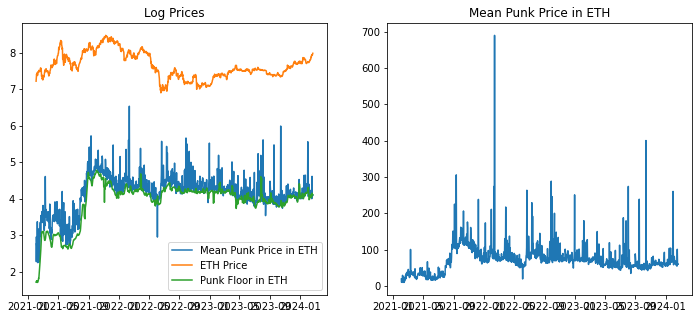

In [2]:
plot_eth_and_punk_prices(sales)

In [2]:

relevant_columns_model = ['amount_original', 'CP Price',
       'Category', 'Front Beard Dark', 'VR', 'Clown Eyes Green',
       'Buck Teeth', 'Wild Hair', 'Silver Chain', 'Cigarette',
       'Purple Eye Shadow', 'Pigtails', 'Handlebars', 'Normal Beard',
       'Blonde Bob', 'Muttonchops', 'Smile', 'Shaved Head', 'Mustache',
       'Mohawk Dark', 'Straight Hair', 'Choker', 'Regular Shades',
       'Peak Spike', 'Tassle Hat', 'Dark Hair', 'Knitted Cap', 'Bandana',
       'Pink With Hat', 'Gold Chain', 'Mohawk', 'Welding Goggles',
       'Cap Forward', 'Tiara', 'Purple Lipstick', 'Small Shades',
       'Stringy Hair', 'Do-rag', 'Wild White Hair', 'Frown', 'Red Mohawk',
       'Half Shaved', 'Clown Hair Green', 'Vampire Hair', 'Beanie',
       'Clown Nose', 'Messy Hair', 'Blonde Short', 'Mole', 'Purple Hair',
       'Chinstrap', 'Orange Side', 'Hot Lipstick', 'Horned Rim Glasses', 'Cap',
       'Green Eye Shadow', 'Nerd Glasses', 'Rosy Cheeks', 'Pilot Helmet',
       'Straight Hair Dark', 'Medical Mask', 'Frumpy Hair', 'Wild Blonde',
       'Hoodie', 'Earring', 'Big Shades', 'Spots', 'Headband', 'Goat',
       'Big Beard', 'Classic Shades', 'Clown Eyes Blue', 'Blue Eye Shadow',
       'Cowboy Hat', 'Luxurious Beard', 'Crazy Hair', 'Normal Beard Black',
       'Fedora', 'Straight Hair Blonde', 'Vape', 'Mohawk Thin', 'Front Beard',
       '3D Glasses', 'Police Cap', 'Top Hat', 'Shadow Beard', 'Eye Mask',
       'Black Lipstick', 'Eye Patch', 'Pipe', 'relative_month_number',  
       'skin_Arab', 'skin_Black', 'skin_Latino', 'skin_white', 'Gender_Alien',
        'Gender_Ape','Gender_Female', 'Gender_Male', 'Gender_Zombie', 'Ethereum_Price']
sales = sales[relevant_columns_model]



sales = sales.dropna(subset = 'amount_original')

sales.reset_index(inplace=True, drop=True)

X = sales[pd.Series(sales.columns)[pd.Series(sales.columns)!='amount_original'].values]
#X = X.drop(['skin_Ape', 'skin_Zombie', 'skin_Alien'], axis=1)
y = sales['amount_original']  # Your target vector

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
class ComplexRegressionNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(ComplexRegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, output_size)
        
    def forward(self, x):
        x = self.dropout1(self.relu1(self.bn1(self.fc1(x))))
        x = self.dropout2(self.relu2(self.bn2(self.fc2(x))))
        x = self.relu3(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

Epoch 1/10, Train Loss: 12889.0351, Train MAPE: 87.28%, Validation Loss: 1382.6346, Validation MAPE: 80.44%, Epoch Time: 1.37 seconds
Epoch 2/10, Train Loss: 12345.5313, Train MAPE: 57.54%, Validation Loss: 964.2877, Validation MAPE: 41.48%, Epoch Time: 0.98 seconds
Epoch 3/10, Train Loss: 12207.9963, Train MAPE: 44.97%, Validation Loss: 942.4729, Validation MAPE: 44.36%, Epoch Time: 0.82 seconds
Epoch 4/10, Train Loss: 12092.3209, Train MAPE: 41.06%, Validation Loss: 1245.3271, Validation MAPE: 69.48%, Epoch Time: 0.75 seconds
Epoch 5/10, Train Loss: 12110.1409, Train MAPE: 41.12%, Validation Loss: 878.2466, Validation MAPE: 37.88%, Epoch Time: 0.85 seconds
Epoch 6/10, Train Loss: 11981.7174, Train MAPE: 36.63%, Validation Loss: 854.5718, Validation MAPE: 36.52%, Epoch Time: 0.83 seconds
Epoch 7/10, Train Loss: 12002.1716, Train MAPE: 36.38%, Validation Loss: 861.0090, Validation MAPE: 20.14%, Epoch Time: 0.84 seconds
Epoch 8/10, Train Loss: 12062.5972, Train MAPE: 41.39%, Validation 

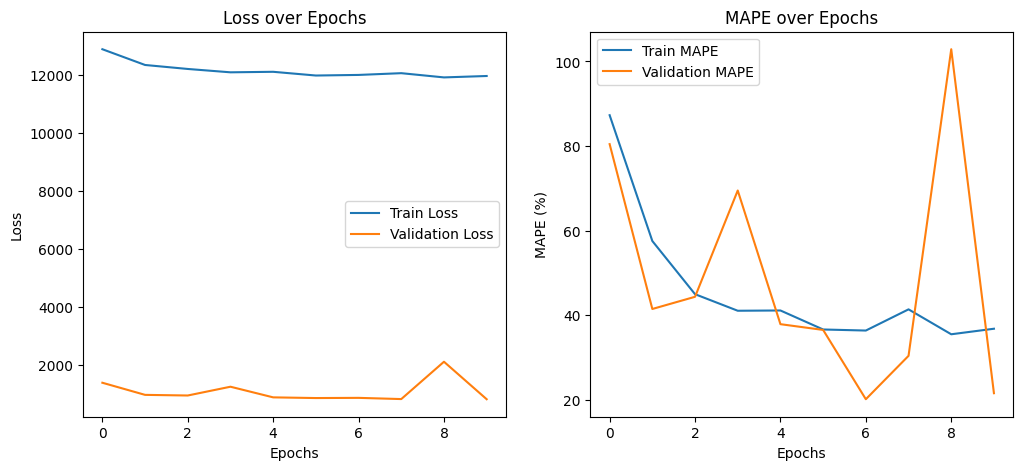

In [48]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Assuming X_train, X_test, y_train, y_test are already defined
# Convert your numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values.astype(np.float32)).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move tensors to the specified device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Create TensorDatasets and DataLoader for both training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Define the Neural Network
class RegressionNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(RegressionNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, output_size)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

# Instantiate the model and move it to the device
model = RegressionNN(input_size=X_train.shape[1], output_size=1).to(device)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_losses, val_losses = [], []
train_mapes, val_mapes = [], []
# Training loop
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    train_loss = 0.0
    train_mape = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_mape += mean_absolute_percentage_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy())

    avg_train_loss = train_loss / len(train_loader)
    avg_train_mape = train_mape / len(train_loader)
    train_losses.append(avg_train_loss)
    train_mapes.append(avg_train_mape)
    
    # Validation loss
    model.eval()
    val_loss = 0.0
    val_mape = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            val_mape += mean_absolute_percentage_error(targets.cpu().numpy(), outputs.cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    avg_val_mape = val_mape / len(test_loader)
    val_losses.append(avg_val_loss)
    val_mapes.append(avg_val_mape)

    end_time = time.time()
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Train MAPE: {train_mape/len(train_loader):.2f}%, '
          f'Validation Loss: {val_loss/len(test_loader):.4f}, '
          f'Validation MAPE: {val_mape/len(test_loader):.2f}%, '
          f'Epoch Time: {end_time - start_time:.2f} seconds')
    


# Testing loop - Evaluation
model.eval()
val_loss = 0.0
val_mape = 0.0
predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)  # Move data to the device
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())  # Move predictions back to CPU

# Flatten the list of arrays into a single array
predictions = np.concatenate(predictions, axis=0)

plt.figure(figsize=(12, 5))

# Plot for training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training and validation MAPE
plt.subplot(1, 2, 2)
plt.plot(train_mapes, label='Train MAPE')
plt.plot(val_mapes, label='Validation MAPE')
plt.title('MAPE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAPE (%)')
plt.legend()

plt.show()

In [49]:
id_punk = 11

floor_price = get_punk_floor_today()
eth = get_ethereum_price_history()
id_punk = 4156
punk_metadata = metadata[metadata.ID == id_punk]

predict_price_punk_today = punk_metadata.copy()
predict_price_punk_today['Ethereum_Price'] = eth.iloc[-1]['Ethereum_Price']
predict_price_punk_today['CP Price'] = floor_price
predict_price_punk_today['relative_month_number'] = sales.relative_month_number.max()

import torch
from torch.utils.data import DataLoader, TensorDataset

entry = predict_price_punk_today[pd.Series(relevant_columns_model)[pd.Series(relevant_columns_model)!='amount_original']]

single_instance_tensor = torch.tensor(entry.values.astype(np.float32))
single_dataset = TensorDataset(single_instance_tensor)
single_loader = DataLoader(single_dataset, batch_size=1, shuffle=False)

predictions = [] 

with torch.no_grad():
    for batch in single_loader:
        inputs = batch[0].to(device) 
        outputs = model(inputs)
        prediction = outputs.cpu().numpy()
prediction[0][0]

78.472145

Mean absolute error: 20.130743564030666
MAPE: 29.183018313708445


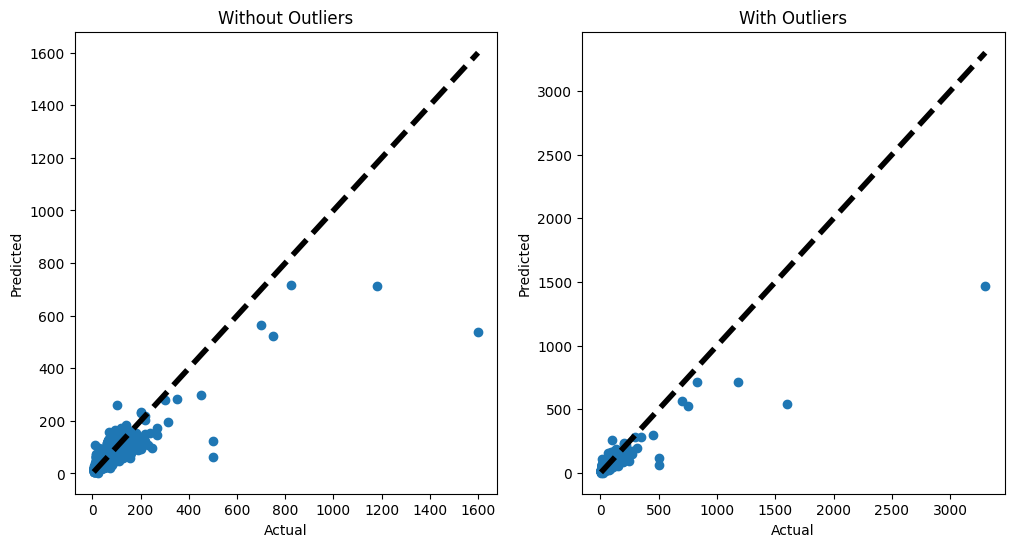

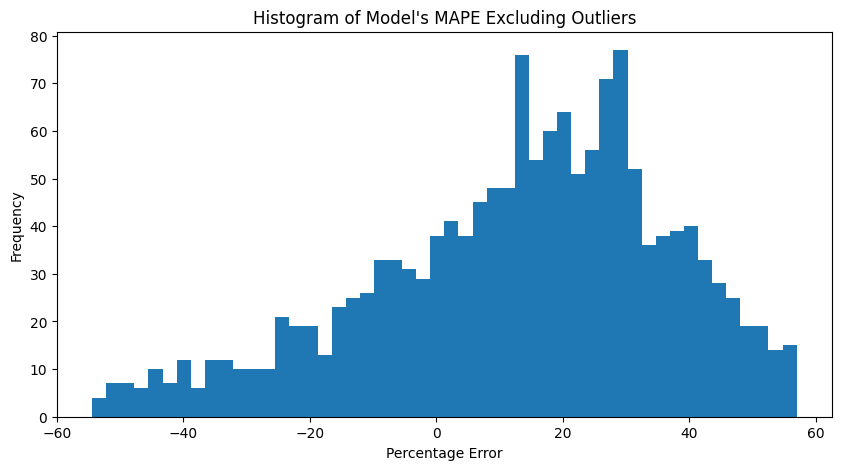

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'predictions' is a numpy array containing your model's predictions for X_test
# Convert your y_test to numpy array if it's not already
y_test_np = y_test.to_numpy()

# Prepare the X_test_eval DataFrame
X_test_eval = pd.DataFrame(X_test)  # Ensure X_test is in a suitable format for creating a DataFrame
X_test_eval['y_pred_nn'] = predictions  # Add your model's predictions
X_test_eval['y_test'] = y_test_np  # Add the actual test values
X_test_eval['error'] = X_test_eval['y_test'] - X_test_eval['y_pred_nn']
X_test_eval['perc_error'] = ((1 - (X_test_eval['y_test'] / X_test_eval['y_pred_nn'])) * 100)
X_test_eval['perc_error_abs'] = X_test_eval['perc_error'].abs()

# Calculate and print MAE and MAPE
print('Mean absolute error:', X_test_eval['error'].abs().mean())
print('MAPE:', X_test_eval['perc_error_abs'].mean())

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Without outliers
subset_no_outliers = X_test_eval[(X_test_eval['y_test'] < 2000) & (X_test_eval['y_pred_nn'] < 2000)]
axs[0].scatter(subset_no_outliers['y_test'], subset_no_outliers['y_pred_nn'])
axs[0].plot([subset_no_outliers['y_test'].min(), subset_no_outliers['y_test'].max()], [subset_no_outliers['y_test'].min(), subset_no_outliers['y_test'].max()], 'k--', lw=4)
axs[0].set_title('Without Outliers')
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('Predicted')

# With outliers
axs[1].scatter(X_test_eval['y_test'], X_test_eval['y_pred_nn'])
axs[1].plot([X_test_eval['y_test'].min(), X_test_eval['y_test'].max()], [X_test_eval['y_test'].min(), X_test_eval['y_test'].max()], 'k--', lw=4)
axs[1].set_title('With Outliers')
axs[1].set_xlabel('Actual')
axs[1].set_ylabel('Predicted')

plt.show()

series_perc_error = exclude_top_and_bottom_x_percent(X_test_eval['perc_error'], 5)
plt.figure(figsize=(10, 5))
plt.hist(series_perc_error, bins=50)
plt.title("Histogram of Model's MAPE Excluding Outliers")
plt.xlabel('Percentage Error')
plt.ylabel('Frequency')
plt.show()


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 13385, number of used features: 98
[LightGBM] [Info] Using GPU Device: GeForce GTX 960, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.10 MB) transferred to GPU in 0.004190 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 63.459432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

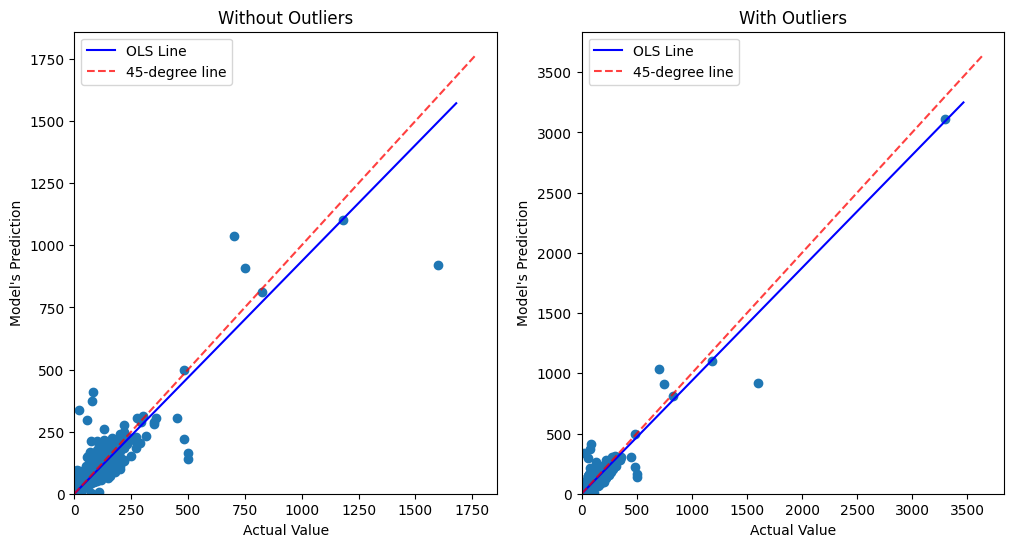

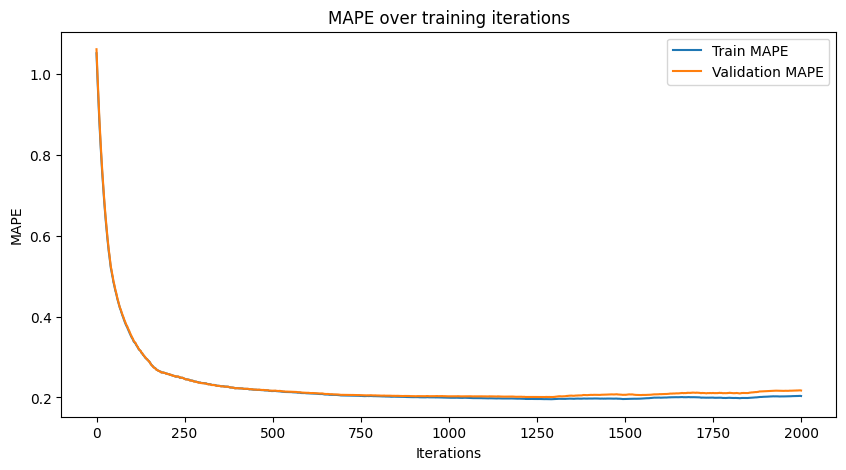

Axes(0.125,0.11;0.775x0.77)


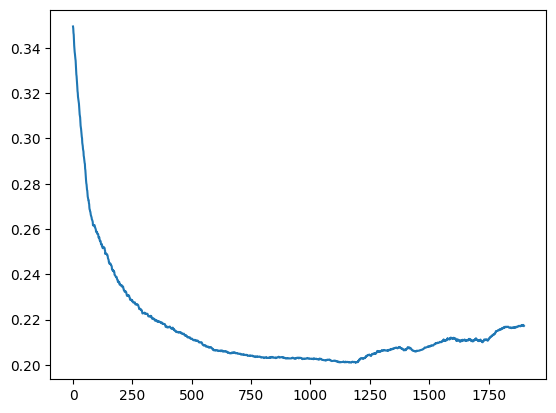

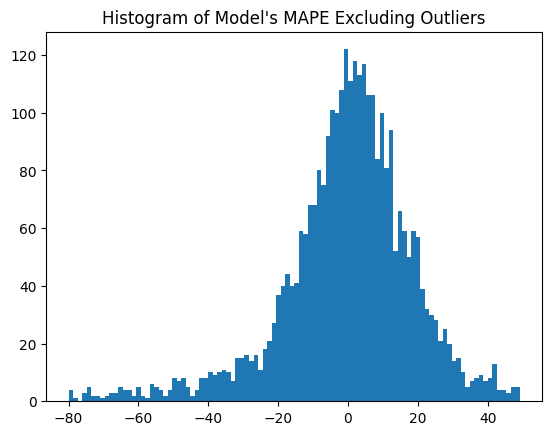

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_test, label=y_test, reference=dtrain)

params = {'objective': 'regression',
    'metric': 'mape',
    'device': 'gpu', 'max_depth': 4, 'min_child_weight': 2, 'gamma': 2.96506457602541, 'subsample': 0.6434374753552159, 'colsample_bytree': 0.9312202821412009, 'learning_rate': 0.030685343020770497, 'num_leaves': 100, 'reg_lambda': 3.3667451982299914, 'reg_alpha': 2.3846500834839954}
# params = {'objective': 'regression', 'metric': 'mape', 'device': 'gpu' }

evals={}

bst = lgb.train(params = params, train_set = dtrain, valid_sets=[dtrain, dval], valid_names=['train', 'val'], num_boost_round=1000,
                callbacks=[
                        #lgb.early_stopping(stopping_rounds=300), 
                        lgb.record_evaluation(evals)] )


X_test_eval = X_test.copy()
X_test_eval['y_pred_gb_lgb'] = bst.predict(X_test_eval, num_iteration=bst.best_iteration)
X_test_eval['y_test'] = y_test
X_test_eval['error'] = X_test_eval['y_test'] - X_test_eval['y_pred_gb_lgb']
X_test_eval['perc_error']  = ((1- (X_test_eval['y_test']/X_test_eval['y_pred_gb_lgb']))*100)
X_test_eval['perc_error_abs'] = X_test_eval.perc_error.abs()

print('Mean absolute error in ETH', X_test_eval['error'].abs().mean())
print('MAPE', X_test_eval['perc_error_abs'].mean())

# Create two subplots one with outliers and one without
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

subset_no_outliers = X_test_eval[(X_test_eval['y_test'] < 2000) & (X_test_eval['y_pred_gb_lgb'] < 2000)]
plot_scatter_predictions_and_actuals_with_OLS(axs[0], subset_no_outliers, 'Without Outliers')
plot_scatter_predictions_and_actuals_with_OLS(axs[1], X_test_eval, 'With Outliers')

plt.figure(figsize=(10, 5))
plt.plot(evals['train']['mape'], label='Train MAPE')
plt.plot(evals['val']['mape'], label='Validation MAPE')
plt.xlabel('Iterations')
plt.ylabel('MAPE')
plt.title('MAPE over training iterations')
plt.legend()
plt.show()

print(pd.Series(evals['val']['mape'][100:]).plot())

# Histogram of the error of the model
series_perc_error = exclude_top_and_bottom_x_percent(X_test_eval['perc_error'], 5)
fig, ax = plt.subplots()
counts, bin_edges = np.histogram(series_perc_error, bins=100)
ax.hist(bin_edges[:-1], bin_edges, weights=counts)
ax.set_title('Histogram of Model\'s MAPE Excluding Outliers')
plt.show()

In [ ]:
import requests
def get_punk_floor_today():
    url = "https://api.opensea.io/api/v2/collections/cryptopunks/stats"

    headers = {
        "accept": "application/json",
        "x-api-key": "d2162577acee4cdfa2cf20e92f37409e"
    }

    response = requests.get(url, headers=headers)

    return response.json()['intervals'][1]['average_price']

def predict_price_of_a_punk_today(id_punk, eth_price, floor_price, relative_month_number):
    
    punk_metadata = metadata[metadata.ID == id_punk]

    predict_price_punk_today = punk_metadata.copy()
    predict_price_punk_today['Ethereum_Price'] = eth_price
    predict_price_punk_today['CP Price'] = floor_price
    predict_price_punk_today['relative_month_number'] = relative_month_number

    return bst.predict(predict_price_punk_today[pd.Series(relevant_columns_model)[pd.Series(relevant_columns_model)!='amount_original']], num_iteration=bst.best_iteration)[0]

id_punk = 11

floor_price = get_punk_floor_today()
eth = get_ethereum_price_history()

id_punk = 6267

predict_price_of_a_punk_today( id_punk = id_punk, 
                               eth_price = eth.iloc[-1]['Ethereum_Price'], 
                               floor_price = floor_price, 
                               relative_month_number = sales.relative_month_number.max())

In [41]:
import onnx

# Load the ONNX model
model = onnx.load("regression_test.onnx")

# Print information about inputs
for input_tensor in model.graph.input:
    input_name = input_tensor.name
    print(input_name)
import onnx
# Generate the graph
pydot_graph = GetPydotGraph(model.graph, name=model.graph.name, rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring", color="yellow",
                                                            fillcolor="yellow", style="filled"))
graph_file = 'onnx_model_visualization.png'
pydot_graph.write_png(graph_file)

print(f"ONNX model visualization saved to {graph_file}")


input
ONNX model visualization saved to onnx_model_visualization.png


In [39]:
# Make sure the model is in evaluation mode
model.eval()

# Create a sample input tensor. The shape should match your model's input shape
# In this case, we're assuming the input has a shape of (batch_size, input_features),
# where input_features should be the number of features in your dataset
sample_input = torch.randn(1, X_train.shape[1]).to(device)

# Specify a path for the ONNX model
onnx_model_path = 'regression_test.onnx'
# Export the model to ONNX format
torch.onnx.export(model,                        # model being run
                  sample_input,                 # model input (or a tuple for multiple inputs)
                  onnx_model_path,              # where to save the model
                  export_params=True,           # store the trained parameter weights inside the model file
                  opset_version=12,             # the ONNX version to export the model to
                  do_constant_folding=True,     # whether to execute constant folding for optimization
                  input_names=['input'],        # the model's input names
                  output_names=['output'],      # the model's output names
                  dynamic_axes={'input': {0: 'batch_size'},  # variable length axes
                                'output': {0: 'batch_size'}})


In [8]:
X_test_eval[['y_test', 'y_pred_nn']]

,y_test,y_pred_nn
13395,29.92,20.873964
13396,38.33,28.025518
13397,25.99,22.628056
13398,19.50,22.543489
13399,19.50,22.467733
...,...,...
16739,75.00,62.368534
16740,58.00,67.746498
16741,51.35,64.297546
16742,178.00,251.385223


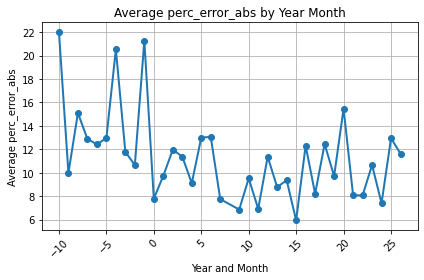

In [13]:
X_test_eval.groupby('relative_month_number').mean()['perc_error_abs'].plot(kind='line', marker='o', linestyle='-', linewidth=2, markersize=6)

plt.title('Average perc_error_abs by Year Month')  # Title of the plot
plt.xlabel('Year and Month')  # X-axis label
plt.ylabel('Average perc_error_abs')  # Y-axis label
plt.grid(True)  # Show grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()

In [38]:
feature_importance_df#[feature_importance_df['Feature Name'] == 'Ethereum_Price']

,Feature Name,Importance
0,CP_Price,3020
89,relative_month_number,2113
1,Category,649
91,skin_Black,329
90,skin_Arab,186
...,...,...
43,Beanie,0
39,Red_Mohawk,0
94,Gender_Alien,0
95,Gender_Ape,0


In [32]:
X_test

,CP Price,Category,Front Beard Dark,VR,Clown Eyes Green,Buck Teeth,Wild Hair,Silver Chain,Cigarette,Purple Eye Shadow,...,relative_month_number,skin_Arab,skin_Black,skin_Latino,skin_white,Gender_Alien,Gender_Ape,Gender_Female,Gender_Male,Gender_Zombie
511,46.010000,3,0,0,1,0,0,0,0,0,...,-4,False,False,True,False,False,False,True,False,False
5863,55.112500,3,0,0,0,0,0,0,1,0,...,0,False,False,True,False,False,False,False,True,False
1302,15.120000,3,0,0,0,0,0,0,0,0,...,-6,False,True,False,False,False,False,False,True,False
11971,48.560550,2,0,0,0,0,0,0,0,0,...,13,False,False,True,False,False,False,False,True,False
6335,59.583333,3,0,0,0,0,0,0,0,0,...,25,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5118,74.197500,3,0,0,0,0,0,0,0,0,...,7,False,True,False,False,False,False,False,True,False
12283,80.192500,2,0,0,0,0,0,0,1,0,...,-1,False,False,False,True,False,False,True,False,False
11881,16.005000,2,0,0,0,0,0,0,0,0,...,-7,False,False,True,False,False,False,True,False,False
4029,19.092045,3,0,0,1,0,0,0,0,0,...,-8,False,False,True,False,False,False,True,False,False


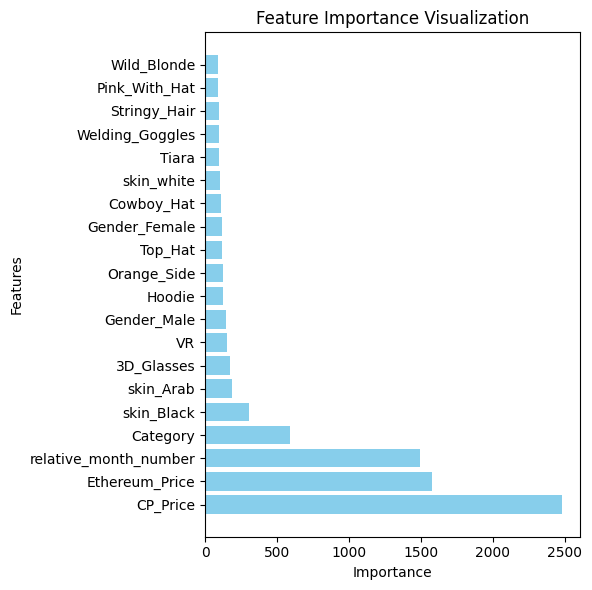

In [58]:
# Get feature importance
importance = bst.feature_importance()

# Get feature names
feature_names = bst.feature_name()

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance': importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_df =feature_importance_df[:20]
# Creating the plot
plt.figure(figsize=(6, 6))
plt.barh(feature_importance_df['Feature Name'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance Visualization')
plt.tight_layout()

# Show the plot
plt.show()

,Feature Name,Importance
25,Vape,16
26,Small_Shades,17
27,Rosy_Cheeks,18
28,Purple_Lipstick,18
29,Headband,19
30,Purple_Eye_Shadow,21
31,Clown_Hair_Green,22
32,Black_Lipstick,23
33,Clown_Eyes_Green,25
34,Wild_Hair,26


CP Price
Category
Front Beard Dark
VR
Clown Eyes Green
Buck Teeth
Wild Hair
Silver Chain
Cigarette
Purple Eye Shadow
Pigtails
Handlebars
Normal Beard
Blonde Bob
Muttonchops
Smile
Shaved Head
Mustache
Mohawk Dark
Straight Hair
Choker
Regular Shades
Peak Spike
Tassle Hat
Dark Hair
Knitted Cap
Bandana
Pink With Hat
Gold Chain
Mohawk
Welding Goggles
Cap Forward
Tiara
Purple Lipstick
Small Shades
Stringy Hair
Do-rag
Wild White Hair
Frown
Red Mohawk
Half Shaved
Clown Hair Green
Vampire Hair
Beanie
Clown Nose
Messy Hair
Blonde Short
Mole
Purple Hair
Chinstrap
Orange Side
Hot Lipstick
Horned Rim Glasses
Cap
Green Eye Shadow
Nerd Glasses
Rosy Cheeks
Pilot Helmet
Straight Hair Dark
Medical Mask
Frumpy Hair
Wild Blonde
Hoodie
Earring
Big Shades
Spots
Headband
Goat
Big Beard
Classic Shades
Clown Eyes Blue
Blue Eye Shadow
Cowboy Hat
Luxurious Beard
Crazy Hair
Normal Beard Black
Fedora
Straight Hair Blonde
Vape
Mohawk Thin
Front Beard
3D Glasses
Police Cap
Top Hat
Shadow Beard
Eye Mask
Black Lipstic

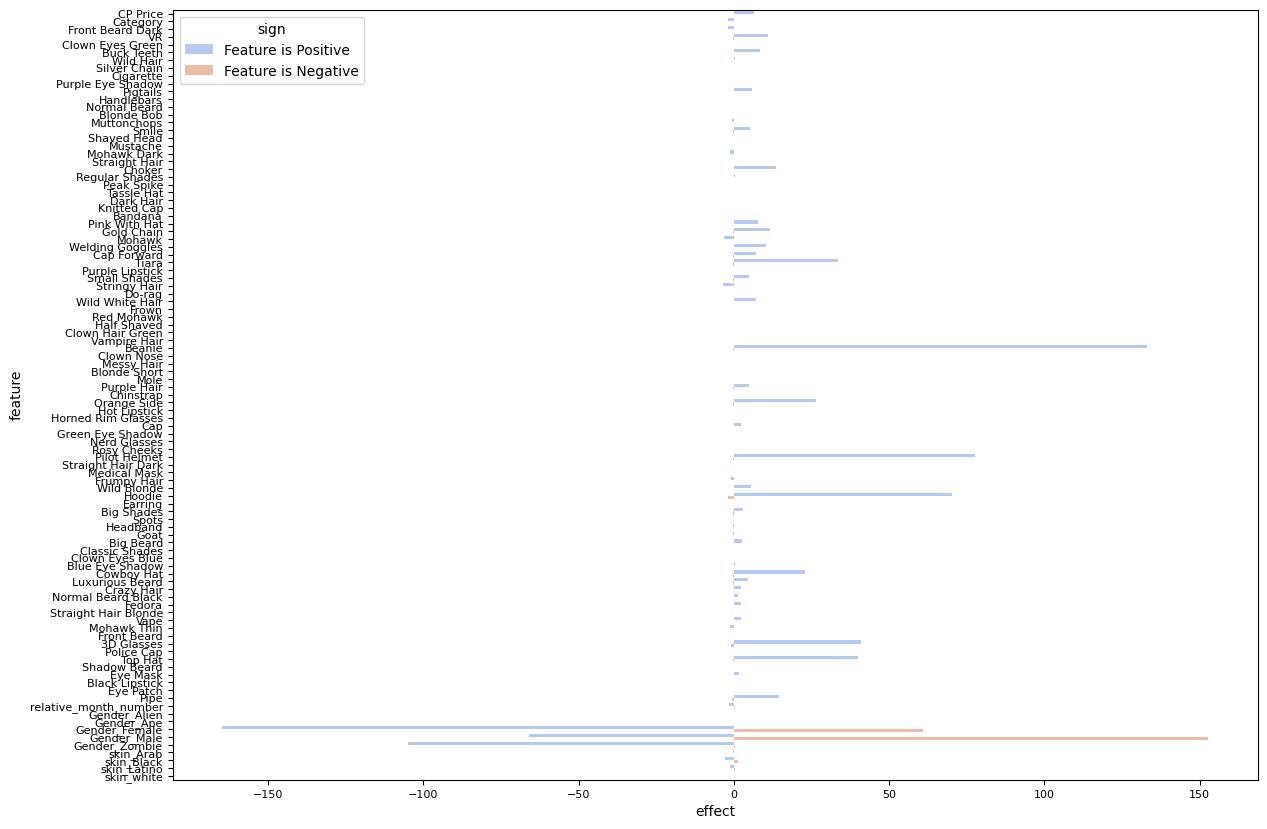

In [ ]:
# Explainable AI
chosen_model = bst  

# Explain the model with SHAP
explainer_cv = shap.TreeExplainer(chosen_model)
shap_values_cv = explainer_cv.shap_values(X_test)

try:
    shap_df_cv = pd.DataFrame(shap_values_cv[1], columns=X_test.columns)
except:
    #for xgboost
    shap_df_cv = pd.DataFrame(shap_values_cv, columns=X_test.columns)

shap.initjs()



X_test_shap = X_test.copy()
X_test_shap.columns = X_test_shap.columns+"_value"
shap_df_cv_feature_values = pd.concat([shap_df_cv.reset_index(drop=True), X_test_shap.reset_index(drop=True)], axis=1)

# Append the SHAP values to the aggregate DataFrame
shap_aggregate = shap_df_cv
all_y_test_cv = y_test

shap_aggregate_feature_values = shap_df_cv_feature_values
mean_shap_values = shap_aggregate.mean()

all_y_test_cv.columns = ['y']

manual_effects = pd.DataFrame()

for i, column in enumerate(X_test.columns):
   print(column)

   effects_feature = pd.concat([shap_aggregate_feature_values[[f'{column}', f'{column}_value']].reset_index(drop=True), all_y_test_cv.reset_index(drop=True)], axis=1)
   m_effects = pd.DataFrame()
   m_effects.loc[0, 'feature'] = column
   m_effects.loc[0, 'sign'] = 'Feature is Positive'
   m_effects.loc[0, 'effect'] = effects_feature[effects_feature[f'{column}_value'] >=1][column].median()
   manual_effects =pd.concat([manual_effects, m_effects], axis=0)
   
   m_effects = pd.DataFrame()
   m_effects.loc[0, 'feature'] = column
   m_effects.loc[0, 'sign'] = 'Feature is Negative'
   m_effects.loc[0, 'effect'] =effects_feature[effects_feature[f'{column}_value'] ==0][column].median()
   manual_effects =pd.concat([manual_effects, m_effects], axis=0)


plt.figure(figsize=(14, 10))

sns.barplot(x='effect', y='feature', hue='sign', data=manual_effects, palette='coolwarm')
plt.tick_params(axis='y', labelsize=8)

plt.tick_params(labelsize=8)